In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV
import gc
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import time
from datetime import timedelta, date
from fbprophet import Prophet
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
%matplotlib inline

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
train_df = pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [4]:
train = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())
train.reset_index(inplace=True)

In [5]:
train1_dates = train[train['segment']==1]['application_date']
train2_dates = train[train['segment']==2]['application_date']

In [6]:
add_datepart(train, 'application_date', drop = False)
add_cyclic_datepart(train, 'application_date')

add_datepart(test_df, 'application_date', drop = False)
add_cyclic_datepart(test_df, 'application_date')

,id,segment,application_Year,application_Month,application_Week,application_Day,application_Dayofweek,application_Dayofyear,application_Is_month_end,application_Is_month_start,...,application_Is_year_start,application_Elapsed,application_weekday_cos,application_weekday_sin,application_day_month_cos,application_day_month_sin,application_month_year_cos,application_month_year_sin,application_day_year_cos,application_day_year_sin
0,1,1,2019,7,27,6,5,187,False,False,...,False,1562371200,-0.222521,-0.974928,0.528964,0.848644,-1.000000e+00,1.224647e-16,-0.998186,-0.060213
1,2,1,2019,7,27,7,6,188,False,False,...,False,1562457600,0.623490,-0.781831,0.347305,0.937752,-1.000000e+00,1.224647e-16,-0.997001,-0.077386
2,3,1,2019,7,28,8,0,189,False,False,...,False,1562544000,1.000000,0.000000,0.151428,0.988468,-1.000000e+00,1.224647e-16,-0.995521,-0.094537
3,4,1,2019,7,28,9,1,190,False,False,...,False,1562630400,0.623490,0.781831,-0.050649,0.998717,-1.000000e+00,1.224647e-16,-0.993747,-0.111659
4,5,1,2019,7,28,10,2,191,False,False,...,False,1562716800,-0.222521,0.974928,-0.250653,0.968077,-1.000000e+00,1.224647e-16,-0.991677,-0.128748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,2,2019,10,42,20,6,293,False,False,...,False,1571529600,0.623490,-0.781831,-0.758758,-0.651372,-1.836970e-16,-1.000000e+00,0.309017,-0.951057
176,177,2,2019,10,43,21,0,294,False,False,...,False,1571616000,1.000000,0.000000,-0.612106,-0.790776,-1.836970e-16,-1.000000e+00,0.325342,-0.945596
177,178,2,2019,10,43,22,1,295,False,False,...,False,1571702400,0.623490,0.781831,-0.440394,-0.897805,-1.836970e-16,-1.000000e+00,0.341571,-0.939856
178,179,2,2019,10,43,23,2,296,False,False,...,False,1571788800,-0.222521,0.974928,-0.250653,-0.968077,-1.836970e-16,-1.000000e+00,0.357698,-0.933837


In [7]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['application_Year', 'application_Month', 'application_Week',
       'application_Day', 'application_Dayofweek', 'application_Dayofyear',
       'application_Is_month_end', 'application_Is_month_start',
       'application_Is_quarter_end', 'application_Is_quarter_start',
       'application_Is_year_end', 'application_Is_year_start']
le = LabelEncoder()
for col in cat_cols:
    train[col] = train[col].astype(str)
    test_df[col] = test_df[col].astype(str)
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test_df[col] = le.transform(test_df[col])
    

In [8]:
train1 = train[train['segment']==1].reset_index(drop=True)
train2 = train[train['segment']==2].reset_index(drop=True)

test1 = test_df[test_df['segment']==1].reset_index(drop=True)
test2 = test_df[test_df['segment']==2].reset_index(drop=True)

In [9]:
train1_x = train1.drop(['segment', 'case_count'],axis = 1)
train1_y = train1['case_count']

train2_x = train2.drop(['segment', 'case_count'],axis = 1)
train2_y = train2['case_count']

In [10]:
train1_x = train1_x.drop(['application_Elapsed'], axis = 1)
test1 = test1.drop(['application_Elapsed'], axis = 1)

train2_x = train2_x.drop(['application_Elapsed'], axis = 1)
test2 = test2.drop(['application_Elapsed'], axis = 1)

In [11]:
train1_x_early = train1_x.iloc[:-87,:]
valid1_x_early = train1_x.iloc[-87:,:]

train1_y_early = train1_y.iloc[:-87]
valid1_y_early = train1_y.iloc[-87:]

train2_x_early = train2_x.iloc[:-93,:]
valid2_x_early = train2_x.iloc[-93:,:]

train2_y_early = train2_y.iloc[:-93]
valid2_y_early = train2_y.iloc[-93:]

In [12]:
from lightgbm import LGBMRegressor

gbm1=LGBMRegressor(
        n_estimators=150,
        learning_rate=0.08,
        num_leaves=21,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=20,
        categorical_features = cat_cols
)

gbm1.fit(train1_x_early, train1_y_early)

LGBMRegressor(boosting_type='gbdt',
              categorical_features=['application_Year', 'application_Month',
                                    'application_Week', 'application_Day',
                                    'application_Dayofweek',
                                    'application_Dayofyear',
                                    'application_Is_month_end',
                                    'application_Is_month_start',
                                    'application_Is_quarter_end',
                                    'application_Is_quarter_start',
                                    'application_Is_year_end',
                                    'application_Is_year_start'],
              class_weight=None, colsample_bytree=0.9497036,
              importance_type='split', learning_rate=0.08, max_depth=8,
              min_child_samples=20, min_child_weight=20,
              min_split_gain=0.0222415, n_estimators=150, n_jobs=-1,
              num_leaves=21, objective

In [13]:
from lightgbm import LGBMRegressor

gbm2=LGBMRegressor(
        n_estimators=250,
        learning_rate=0.1,
        num_leaves=24,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.4,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=20,
        categorical_features = cat_cols
)

gbm2.fit(train2_x_early, train2_y_early)

LGBMRegressor(boosting_type='gbdt',
              categorical_features=['application_Year', 'application_Month',
                                    'application_Week', 'application_Day',
                                    'application_Dayofweek',
                                    'application_Dayofyear',
                                    'application_Is_month_end',
                                    'application_Is_month_start',
                                    'application_Is_quarter_end',
                                    'application_Is_quarter_start',
                                    'application_Is_year_end',
                                    'application_Is_year_start'],
              class_weight=None, colsample_bytree=0.9497036,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=20,
              min_split_gain=0.0222415, n_estimators=250, n_jobs=-1,
              num_leaves=24, objective=

In [14]:
test1 = test1.drop(['segment','id'], axis = 1)
test1_pred_gbm = gbm1.predict(test1)

test2 = test2.drop(['segment','id'], axis = 1)
test2_pred_gbm = gbm2.predict(test2)

In [15]:
def GradientBooster1(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state = 3344) 

    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 

    classifier.fit(train1_x, train1_y) 
 
    print(classifier.best_estimator_) 
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100, 120], 
            'learning_rate': [0.1],
            'max_depth':[9, 10],#4,6], 
            'min_samples_split': [3,5],
            'min_samples_leaf':[1,3],#,5,9,17], 
            'max_features':[0.8, 1.0],#,0.3]#,0.1]
            #'min_impurity_decrease':[1.0],
            
            'alpha':[0.8,0.9],
            'subsample': [1.0],
            'criterion':['friedman_mse'], 
            'random_state': [365]
           } 

n_jobs=4 

cv1,best_est1 = GradientBooster1(param_grid, n_jobs)

GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=365, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [16]:
def GradientBooster2(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state = 3344) 

    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 

    classifier.fit(train2_x_early, train2_y_early) 
 
    print(classifier.best_estimator_) 
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100, 120], 
            'learning_rate': [0.1],
            'max_depth':[8, 9],#4,6], 
            'min_samples_split': [3,5],
            'min_samples_leaf':[1,3],#,5,9,17], 
            'max_features':[0.8, 1.0],#,0.3]#,0.1]
            #'min_impurity_decrease':[1.0],
            
            'alpha':[0.8,0.9],
            'subsample': [0.9, 1.0],
            'criterion':['friedman_mse'], 
            'random_state': [365]
           } 

n_jobs=4 

cv2,best_est2 = GradientBooster2(param_grid, n_jobs)

GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=8,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=365, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [17]:
test1_pred_gbr = best_est1.predict(test1)
test2_pred_gbr = best_est2.predict(test2)

In [18]:
train_df = pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [19]:
train = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())
train.reset_index(inplace=True)

In [20]:
train1 = train[train['segment']==1].reset_index(drop=True)
train2 = train[train['segment']==2].reset_index(drop=True)

test1 = test_df[test_df['segment']==1].reset_index(drop=True)
test2 = test_df[test_df['segment']==2].reset_index(drop=True)

test2 = test2.drop(['segment','id'], axis = 1)

In [21]:
train1 = train1.drop(['segment'],axis = 1)
train1.columns = ['ds','y']

In [22]:
fest_dussehra = pd.DataFrame({
                              'holiday': 'dussehra',
                              'ds': pd.to_datetime(['2017-09-30', '2018-10-19', '2019-10-8',])})

fest_chaturthia = pd.DataFrame({
                              'holiday': 'chaturthi',
                              'ds': pd.to_datetime(['2017-08-25', '2018-9-13', '2019-9-2',])})

# fest_navrarti = pd.DataFrame({
#                               'holiday': 'navrarti',
#                               'ds': pd.to_datetime(['2017-9-21', '2017-9-22', '2017-9-23', '2017-9-24', '2017-9-25',
#                                                     '2017-9-26', '2017-9-27', '2017-9-28', '2017-9-29', '2017-9-30', 
#                                                     '2018-10-9', '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-13',
#                                                     '2018-10-14', '2018-10-15', '2018-10-16', '2018-10-17', '2018-10-18',
#                                                     '2019-9-29', '2019-9-30', '2019-10-1', '2019-10-2', '2019-10-3',
#                                                     '2019-10-4', '2019-10-5', '2019-10-6', '2019-10-7', '2019-10-8'])})

# fest_raksabandan = pd.DataFrame({
#                               'holiday': 'raksabandan',
#                               'ds': pd.to_datetime(['2017-08-7', '2018-8-18', '2019-8-19',])})

# fest_janmastmi = pd.DataFrame({
#                               'holiday': 'janmastmi',
#                               'ds': pd.to_datetime(['2017-08-14', '2018-9-2', '2019-8-24',])})

holidays = fest_chaturthia
# holidays = pd.concat((fest_dussehra, fest_chaturthia))
# holidays = pd.concat((holidays, fest_navrarti))
# holidays = pd.concat((holidays, fest_raksabandan))
# holidays = pd.concat((holidays, fest_janmastmi))

In [25]:
m1 = Prophet(holidays = holidays,seasonality_mode='multiplicative')
# m1.add_seasonality(name='monthly', period=30.5, fourier_order=2)
# m1.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
# m1.add_regressor('is_friday')
m1.add_country_holidays(country_name='IN')
m1.fit(train1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Program_Files\Anaconda3\lib\site-packages\fbprophet\hdays.py:256: Warning:

We only support Diwali and Holi holidays from 2010 to 2025



In [26]:
future1 = m1.make_future_dataframe(periods=test1.shape[0])
# future1['is_friday'] = future1['ds'].apply(is_friday)

In [27]:
forecast1 = m1.predict(future1)

In [44]:
test1_pred_prophet = forecast1['yhat'][-87:].values

In [54]:
test1_pred_prophet

array([2760.931587, 1689.520807, 3759.36525 , 3224.188379, ..., 4445.487278, 4022.780308, 2992.794189, 5117.255521])

In [47]:
test1_pred_ens = 0.3*test1_pred_gbm +0.35*test1_pred_gbr+0.35*test1_pred_prophet
test2_pred_ens = 0.5*test2_pred_gbm +0.5*test2_pred_gbr

In [51]:
test1_pred_ens_clipped = np.clip(test1_pred_ens,0,4500)

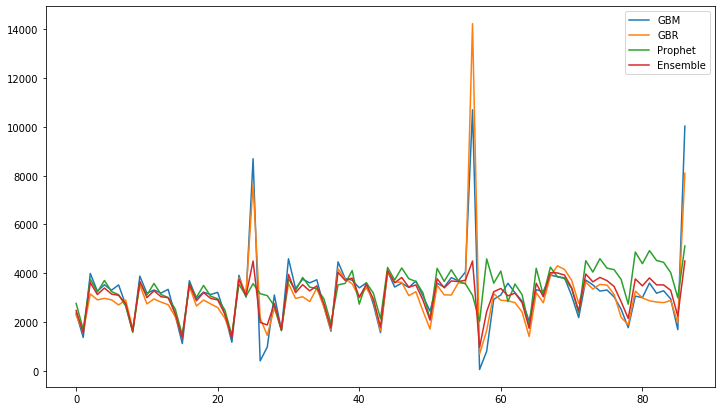

In [52]:
plt.figure(figsize = (12,7))
plt.plot(test1_pred_gbm, label = 'GBM')
plt.plot(test1_pred_gbr, label = 'GBR')
plt.plot(test1_pred_prophet, label = 'Prophet')
plt.plot(test1_pred_ens_clipped, label = 'Ensemble')
plt.legend()

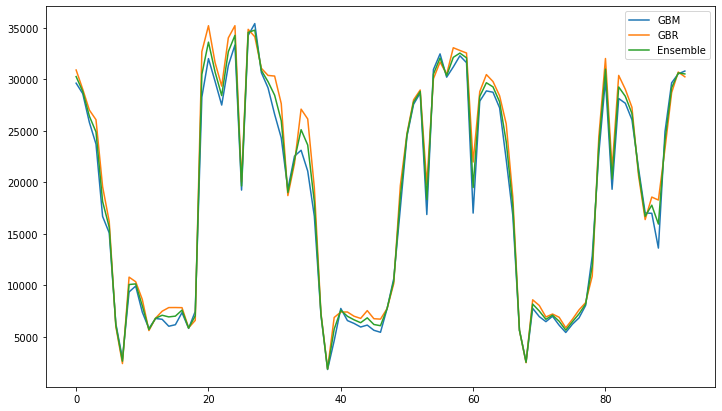

In [49]:
plt.figure(figsize = (12,7))
plt.plot(test2_pred_gbm, label = 'GBM')
plt.plot(test2_pred_gbr, label = 'GBR')
plt.plot(test2_pred_ens, label = 'Ensemble')
plt.legend()

In [53]:
sub = pd.read_csv('sample_submission.csv')

sub['case_count'][sub['segment']==1] = test1_pred_ens_clipped
sub['case_count'][sub['segment']==2] = test2_pred_ens

sub.to_csv('ensemble_1_clipped.csv',index = False)

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

